In [25]:
pip install pennylane --upgrade

In [26]:
#general import
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

In [27]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# For now a Standard Scaler always applied, if not will be specified
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
#This will change in some cases, KEEP AN EYE!
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

In [28]:
print('Shape X_train:', X_train.shape)
print('Shape Y_train', y_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape Y_test:', y_test.shape)

Shape X_train: (75, 4)
Shape Y_train (75,)
Shape X_test: (25, 4)
Shape Y_test: (25,)


In [29]:
y_test

array([ 1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
       -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.])

# Model 6: Leave only the QAOA encoding!

In [30]:
from pennylane.templates import AmplitudeEmbedding, BasisEmbedding, DisplacementEmbedding, QAOAEmbedding
n_qubits = 4
dev_var = qml.device("default.qubit", wires=n_qubits)
#dev_var = qml.device("qiskit.aer", wires=4)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params_):
    """A variational quantum model."""

    # trainable embedding
    QAOAEmbedding(x, wires=range(n_qubits), weights = params_)
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params_, bias):
    """Adding a bias."""
    return quantum_model(x, params_) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [31]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""
    params_ = np.random.random((n_layers, 8))
    params_torch_ = torch.tensor(params_, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch_, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch_, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch_, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params_, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params_, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

In [22]:
n_layers = 4
params_ = np.random.random((n_layers, 8))
print(qml.draw(quantum_model)(X_train[0], params_))

 0: ──RX(0.359)───╭RZ(0.694)──────────────────────────────────────╭RZ(0.464)──RY(0.138)───RX(0.359)───╭RZ(0.948)─────────────────────────────────────╭RZ(0.64)──RY(0.676)───RX(0.359)───╭RZ(0.971)─────────────────────────────────────╭RZ(0.473)──RY(0.984)───RX(0.359)───╭RZ(0.00292)─────────────────────────────────────╭RZ(0.907)──RY(0.239)───RX(0.359)───┤ ⟨Z⟩ 
 1: ──RX(2.73)────╰RZ(0.694)──╭RZ(0.0822)───RY(0.341)──RX(2.73)───│───────────────────────────────────╰RZ(0.948)──╭RZ(0.445)───RY(0.132)──RX(2.73)───│──────────────────────────────────╰RZ(0.971)──╭RZ(0.263)───RY(0.269)──RX(2.73)───│───────────────────────────────────╰RZ(0.00292)──╭RZ(0.0398)───RY(0.47)───RX(2.73)──│───────────────────────────────────┤     
 2: ──RX(-0.944)──────────────╰RZ(0.0822)──╭RZ(0.911)──RY(0.165)──│───────────RX(-0.944)──────────────────────────╰RZ(0.445)──╭RZ(0.789)──RY(0.234)──│──────────RX(-0.944)──────────────────────────╰RZ(0.263)──╭RZ(0.272)──RY(0.407)──│───────────RX(-0.944)────────────────────────────╰

step 0 , loss 0.9020264687162569
step 10 , loss 0.6392023972524093
step 20 , loss 0.35634375426084414
step 30 , loss 0.3592396951106571
step 40 , loss 0.2976656662520498
step 50 , loss 0.4015745616814656
step 60 , loss 0.2559613069146199
step 70 , loss 0.23285485846207504
step 80 , loss 0.24419350245570906
step 90 , loss 0.25543215707445316
step 100 , loss 0.2047280478500137
step 110 , loss 0.19678179661130232
step 120 , loss 0.22313439447988032
step 130 , loss 0.22875072521654874
step 140 , loss 0.24895375591668117
accuracy on test set: 1.0


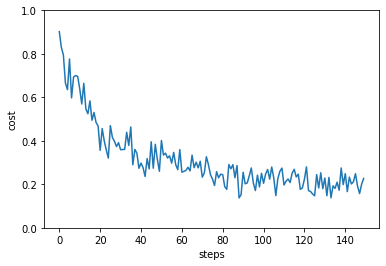

In [23]:
n_layers = 4
batch_size = 20
steps = 150
trained_params_, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params_, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [24]:
dev_var.num_executions

177025

try reducing layers..

step 0 , loss 0.8098337014105199
step 10 , loss 0.6212351104737754
step 20 , loss 0.5322608180072848
step 30 , loss 0.28951589706752345
step 40 , loss 0.3096024867189561
accuracy on test set: 0.88


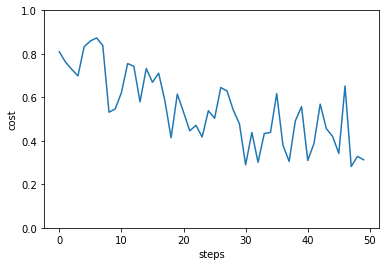

In [32]:
n_layers = 3
batch_size = 20
steps = 50
trained_params_, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params_, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()